In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/173.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/491.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/379.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/248.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/94.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/480.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/236.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/340.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/48.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/513.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/350.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/314.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/227.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/238.png
/kaggle/input/v2-plant-seedlings-dataset/Scentless Mayweed/61.pn

In [2]:
!pip install split-folders

In [3]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Defining the path for train and test data

In [4]:
import splitfolders

input_folder = '/kaggle/input/v2-plant-seedlings-dataset'
output_folder = './dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2))

Copying files: 5539 files [00:59, 92.84 files/s] 


In [5]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('/kaggle/working/dataset/train/*'):
    train_length += len(glob.glob(name+'/*.png'))
for name in glob.glob('/kaggle/working/dataset/test/*'):
    test_length += len(glob.glob(name+'/*.png'))
    
print(train_length, test_length)

4426 1113


In [6]:
batch_size = 32
img_height = 120
img_width = 120

In [7]:
data_dir_train = '/kaggle/working/dataset/train'
data_dir_test = '/kaggle/working/dataset/test'

In [8]:
# creating train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset='training', seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 13 classes.
Using 3541 files for training.


In [9]:
# creating validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                            image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 13 classes.
Using 885 files for validation.


In [10]:
import os
import shutil

folders = ['train', 'test', 'val']

for folder in folders:
    folder_path = f'/kaggle/working/dataset/{folder}/nonsegmentedv2'

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"{folder_path} has been deleted.")
    else:
        print(f"{folder_path} does not exist.")

/kaggle/working/dataset/train/nonsegmentedv2 has been deleted.
/kaggle/working/dataset/test/nonsegmentedv2 has been deleted.
/kaggle/working/dataset/val/nonsegmentedv2 has been deleted.


In [11]:
# Listing out all the classes of plant seedlings and store them in a list.

labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [12]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [13]:
count_plot

[247, 361, 268, 570, 202, 430, 609, 205, 485, 219, 460, 370]

## Visualizing the data

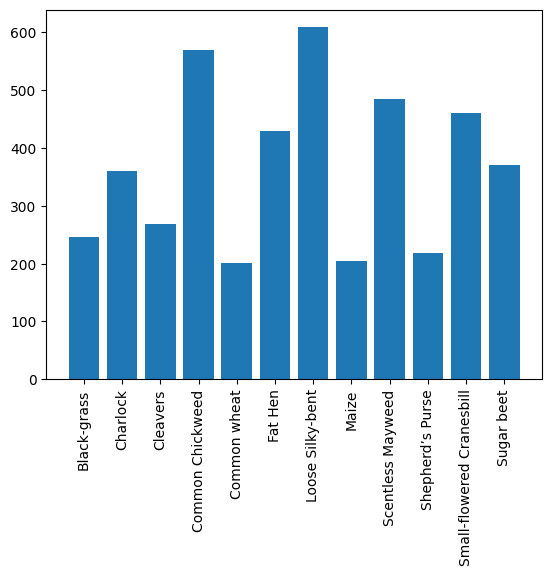

In [14]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

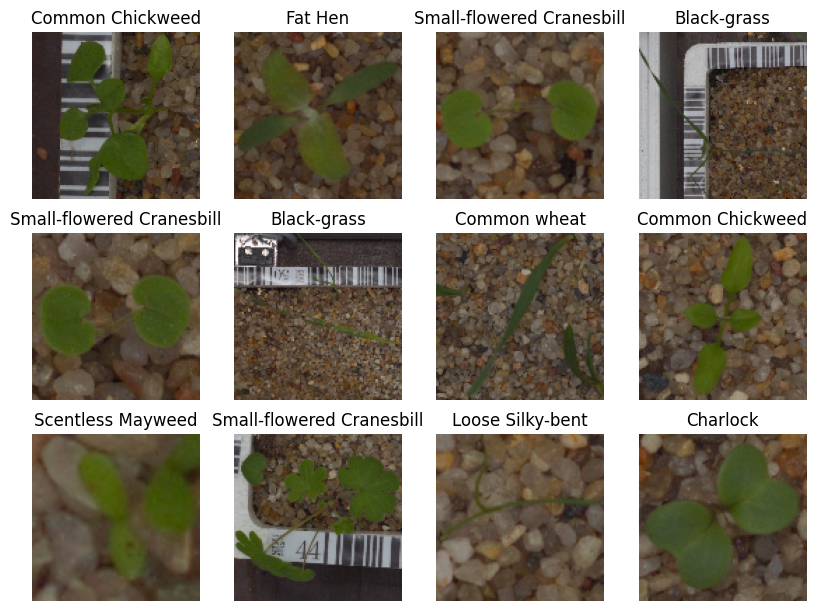

In [15]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(labels[label[i]])
        plt.axis("off")

## Creating the Model 

## Model 1

Creating a CNN model, which can accurately detect 12 classes present in the dataset. Use layers.experimental.preprocessing. Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0,255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0,1]

In [16]:
# specifying image dimensions with RGB channel
input_shape = (120,120,3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating layers for the first model using conv2D
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
# using batch normalization
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [17]:
### Compiling the model
### choosing an appropriate optimizer and loss function

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
### Training the model
epochs = 20
batch_size = 64
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/20
111/111 [==============================] - 34s 157ms/step - loss: 3.1257 - accuracy: 0.5089 - val_loss: 9.3450 - val_accuracy: 0.0452
Epoch 2/20
111/111 [==============================] - 18s 151ms/step - loss: 0.8420 - accuracy: 0.7453 - val_loss: 27.1196 - val_accuracy: 0.0452
Epoch 3/20
111/111 [==============================] - 20s 167ms/step - loss: 0.4859 - accuracy: 0.8345 - val_loss: 24.4199 - val_accuracy: 0.0734
Epoch 4/20
111/111 [==============================] - 18s 154ms/step - loss: 0.3349 - accuracy: 0.8879 - val_loss: 9.1324 - val_accuracy: 0.2203
Epoch 5/20
111/111 [==============================] - 18s 150ms/step - loss: 0.2816 - accuracy: 0.9085 - val_loss: 3.8686 - val_accuracy: 0.4847
Epoch 6/20
111/111 [==============================] - 18s 153ms/step - loss: 0.2087 - accuracy: 0.9288 - val_loss: 1.6030 - val_accuracy: 0.7051
Epoch 7/20
111/111 [==============================] - 17s 140ms/step - loss: 0.1504 - accuracy: 0.9551 - val_loss: 1.7853 - val_

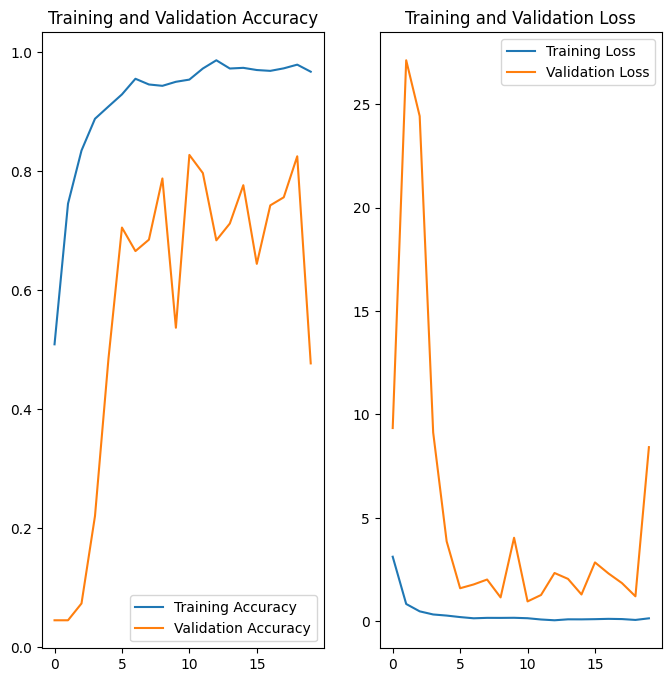

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2

In [20]:
input_shape = (120,120,3)
num_classes = 12

model2 = Sequential()
# adding layers for normalizing the images between 0 and 1
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(32, kernel_size=(3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.20))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [21]:
### compiling the model
### choosing an appropriate optimizer and loss function
opt = Adam(0.001) # specifying the optimizer used for the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
# giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Creating the callback for early stopping 
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [23]:
### training the model and using callback parameter to save the best model
epochs = 10
batch_size = 64
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/10


2023-11-01 04:17:27.261360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


111/111 [==============================] - ETA: 0s - loss: 2.4377 - accuracy: 0.1288
Epoch 1: val_loss improved from inf to 2.41659, saving model to Seed2/model-00001-2.43772-2.41659-.h5
111/111 [==============================] - 20s 144ms/step - loss: 2.4377 - accuracy: 0.1288 - val_loss: 2.4166 - val_accuracy: 0.1379
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 1.9546 - accuracy: 0.3493
Epoch 2: val_loss improved from 2.41659 to 1.52928, saving model to Seed2/model-00002-1.95456-1.52928-.h5
111/111 [==============================] - 17s 142ms/step - loss: 1.9546 - accuracy: 0.3493 - val_loss: 1.5293 - val_accuracy: 0.4599
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 1.2614 - accuracy: 0.5781
Epoch 3: val_loss improved from 1.52928 to 1.07236, saving model to Seed2/model-00003-1.26135-1.07236-.h5
111/111 [==============================] - 17s 142ms/step - loss: 1.2614 - accuracy: 0.5781 - val_loss: 1.0724 - val_accuracy: 0.6429
Epoch 4

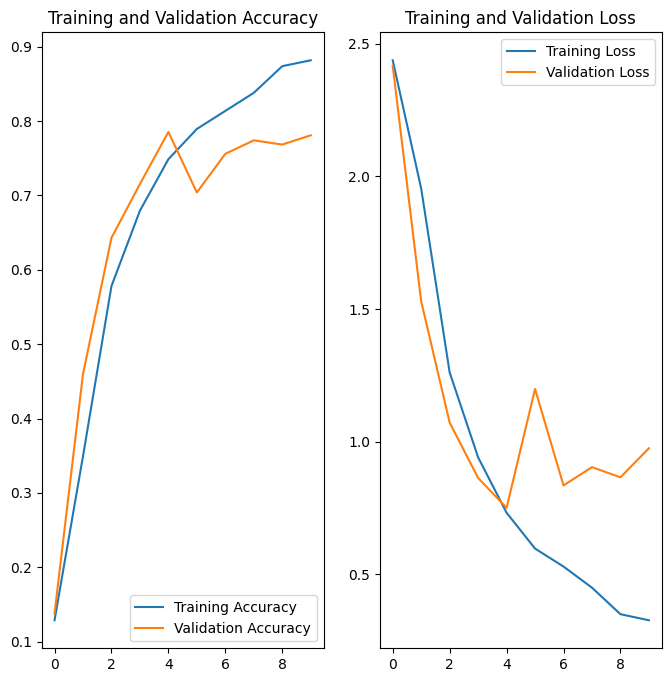

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model 3 

## With Data Augmentation

In [25]:
input_shape = (120,120,3)
num_classes = 12

model_aug = Sequential()
# Scaling the images
model_aug.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
#layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
#layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model_aug.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(32, kernel_size=(3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
# adding dropout layer after each Maxpooling layer
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(128, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.20))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [26]:
### compiling the augmented model
### choosing an appropriat optimizer and loss function

opt = Adam(0.001)
model_aug.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [28]:
### training the model
epochs = 10
batch_size = 64
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Epoch 1/10


2023-11-01 04:20:28.010281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


111/111 [==============================] - ETA: 0s - loss: 2.4413 - accuracy: 0.1333
Epoch 1: val_loss improved from inf to 2.42780, saving model to Seed3/model-00001-2.44127-2.42780-.h5
111/111 [==============================] - 21s 146ms/step - loss: 2.4413 - accuracy: 0.1333 - val_loss: 2.4278 - val_accuracy: 0.1379
Epoch 2/10
111/111 [==============================] - ETA: 0s - loss: 2.4114 - accuracy: 0.1426
Epoch 2: val_loss improved from 2.42780 to 2.25461, saving model to Seed3/model-00002-2.41144-2.25461-.h5
111/111 [==============================] - 18s 149ms/step - loss: 2.4114 - accuracy: 0.1426 - val_loss: 2.2546 - val_accuracy: 0.2350
Epoch 3/10
111/111 [==============================] - ETA: 0s - loss: 1.7682 - accuracy: 0.3589
Epoch 3: val_loss improved from 2.25461 to 1.49576, saving model to Seed3/model-00003-1.76817-1.49576-.h5
111/111 [==============================] - 17s 147ms/step - loss: 1.7682 - accuracy: 0.3589 - val_loss: 1.4958 - val_accuracy: 0.4870
Epoch 4

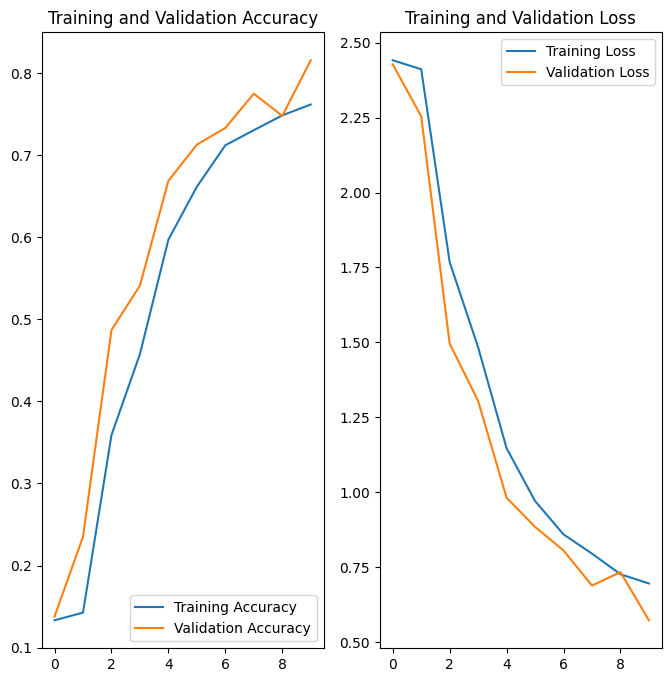

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
train_path = '/kaggle/working/dataset/train/'
test_path = '/kaggle/working/dataset/test/'

In [31]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 268 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 430 samples.
Loose Silky-bent has 609 samples.
Maize has 205 samples.
Scentless Mayweed has 485 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.


In [32]:
!pip install Augmentor

In [33]:
train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(train_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 247 image(s) found.
Output directory set to /kaggle/working/dataset/train/Black-grass/output.

Processing <PIL.Image.Image image mode=RGB size=154x154 at 0x7EB2BD5AF370>: 100%|██████████| 500/500 [01:11<00:00,  7.03 Samples/s]


Initialised with 361 image(s) found.
Output directory set to /kaggle/working/dataset/train/Charlock/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=486x486 at 0x7EB2BD53ED10>: 100%|██████████| 500/500 [00:30<00:00, 16.21 Samples/s]


Initialised with 268 image(s) found.
Output directory set to /kaggle/working/dataset/train/Cleavers/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=464x464 at 0x7EB2BD557340>: 100%|██████████| 500/500 [00:14<00:00, 35.11 Samples/s]


Initialised with 570 image(s) found.
Output directory set to /kaggle/working/dataset/train/Common Chickweed/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=192x192 at 0x7EB2BD5D7430>: 100%|██████████| 500/500 [00:10<00:00, 49.99 Samples/s]


Initialised with 202 image(s) found.
Output directory set to /kaggle/working/dataset/train/Common wheat/output.

Processing <PIL.Image.Image image mode=RGB size=315x315 at 0x7EB2BD543A90>: 100%|██████████| 500/500 [00:34<00:00, 14.54 Samples/s]


Initialised with 430 image(s) found.
Output directory set to /kaggle/working/dataset/train/Fat Hen/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=179x179 at 0x7EB2BD56F7F0>: 100%|██████████| 500/500 [00:16<00:00, 30.75 Samples/s]


Initialised with 609 image(s) found.
Output directory set to /kaggle/working/dataset/train/Loose Silky-bent/output.

Processing <PIL.Image.Image image mode=RGB size=218x218 at 0x7EB2BCC17E50>: 100%|██████████| 500/500 [00:38<00:00, 13.01 Samples/s]


Initialised with 205 image(s) found.
Output directory set to /kaggle/working/dataset/train/Maize/output.

Processing <PIL.Image.Image image mode=RGB size=958x958 at 0x7EB1FD3E94B0>: 100%|██████████| 500/500 [00:47<00:00, 10.53 Samples/s]


Initialised with 485 image(s) found.
Output directory set to /kaggle/working/dataset/train/Scentless Mayweed/output.

Processing <PIL.Image.Image image mode=RGB size=89x89 at 0x7EB1D0256080>: 100%|██████████| 500/500 [00:11<00:00, 41.91 Samples/s]


Initialised with 219 image(s) found.
Output directory set to /kaggle/working/dataset/train/Shepherd’s Purse/output.

Processing <PIL.Image.Image image mode=RGB size=155x155 at 0x7EB181362740>: 100%|██████████| 500/500 [00:15<00:00, 32.43 Samples/s]


Initialised with 460 image(s) found.
Output directory set to /kaggle/working/dataset/train/Small-flowered Cranesbill/output.

Processing <PIL.Image.Image image mode=RGB size=959x959 at 0x7EB1E41A3160>: 100%|██████████| 500/500 [00:17<00:00, 29.32 Samples/s]


Initialised with 370 image(s) found.
Output directory set to /kaggle/working/dataset/train/Sugar beet/output.

Processing <PIL.Image.Image image mode=RGB size=206x206 at 0x7EB1D07B3FA0>: 100%|██████████| 500/500 [00:49<00:00, 10.11 Samples/s]


In [34]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 500 samples.
Charlock has 500 samples.
Cleavers has 500 samples.
Common Chickweed has 500 samples.
Common wheat has 500 samples.
Fat Hen has 500 samples.
Loose Silky-bent has 500 samples.
Maize has 500 samples.
Scentless Mayweed has 500 samples.
Shepherd’s Purse has 500 samples.
Small-flowered Cranesbill has 500 samples.
Sugar beet has 500 samples.


In [35]:
batch_size = 32
img_height = 120
img_width = 120

In [36]:
data_dit_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123, label_mode='categorical',
validation_split = 0.2,
subset = 'training',
image_size=(img_height, img_width),
batch_size=batch_size)

Found 10426 files belonging to 12 classes.
Using 8341 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=123, label_mode='categorical',
validation_split = 0.2,
subset = 'validation',
image_size=(img_height, img_width),
batch_size=batch_size)

Found 10426 files belonging to 12 classes.
Using 2085 files for validation.


In [38]:
input_shape = (120,120,3)
num_classes = 12

model4 = Sequential()
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [39]:
### choosing an appropriate optimizer and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# specifying the format in which model needs to be saved
model_name = 'Seed4' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
# giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [41]:
### training the model
epochs = 10
batch_size = 64
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/10


2023-11-01 04:29:58.456089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


261/261 [==============================] - ETA: 0s - loss: 1.9575 - accuracy: 0.3068
Epoch 1: val_loss improved from inf to 1.28156, saving model to Seed4/model-00001-1.95752-1.28156-.h5
261/261 [==============================] - 50s 175ms/step - loss: 1.9575 - accuracy: 0.3068 - val_loss: 1.2816 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 2/10
261/261 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.6363
Epoch 2: val_loss improved from 1.28156 to 0.68320, saving model to Seed4/model-00002-1.02125-0.68320-.h5
261/261 [==============================] - 47s 176ms/step - loss: 1.0212 - accuracy: 0.6363 - val_loss: 0.6832 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 3/10
261/261 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.7537
Epoch 3: val_loss improved from 0.68320 to 0.53113, saving model to Seed4/model-00003-0.67669-0.53113-.h5
261/261 [==============================] - 48s 180ms/step - loss: 0.6767 - accuracy: 0.7537 - val_loss: 0.5311 - va

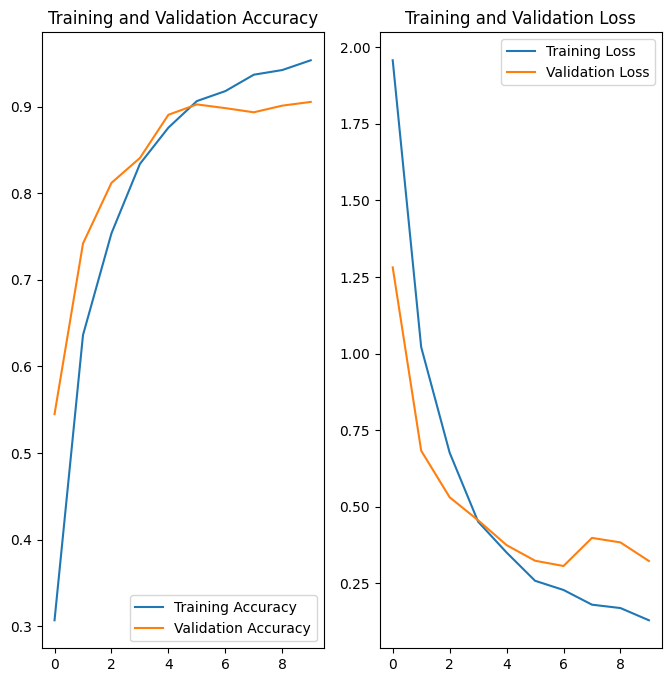

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the Model

In [43]:
model4.save('plant_model.h5')